In [1]:
###############################################################################
# Calculating forces on hydrodynamically and acoustically interacting spheres
# in the Rayleigh limit
# Methods based on Multibody Dynamics in Acoustophoresis (Baasch et al.)
import numpy as np
import pylab as plt
%matplotlib inline 
from matplotlib import animation, rc
from IPython.display import HTML
from time import time
## Fix:
# interparticle distances aren't taking periodic BCs into account (should this even use periodic BCs?)
# Periodic BCs disabled for now, search for % characters to check
# find a reasonable unit system
# check counting for pairwise interactions, loops that explicitly avoid double-counting need to 
#    also make sure that both reciprocal forces are calculated



Run time 74.69654178619385
Anim time 12.270889520645142


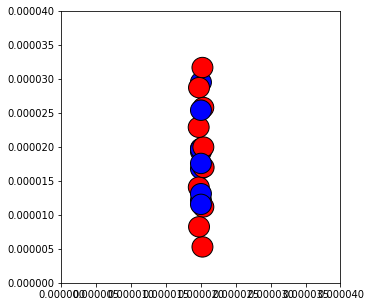

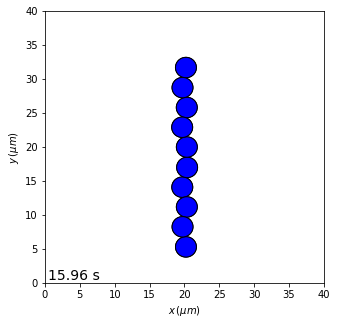

In [150]:
# Calculate physical quantities for the system and non-dimensionalize appropriately
# First calculate everything in SI units:
density_medium = 1000
soundspeed_medium =1480
density_particle = 1180
soundspeed_particle = 1480*1.2 # not known

compress_medium = 1/(density_medium*soundspeed_medium**2)
compress_particle = 1/(density_particle*soundspeed_particle**2)

compress_ratio = compress_particle/compress_medium
density_ratio = density_particle/density_medium

f0 = 1 - compress_ratio
f1 = 2*(density_ratio-1)/(2*density_ratio+1)
f0s = f0
f0p = f0
f1s = f1
f1p = f1 # all particles identical
contrast_factor = f0 + (3/2)*f1 # check this

radius = 1.5*10**(-6)
frequency = 2*10**6
wavelength = soundspeed_medium/frequency
wavenumber = 2*np.pi/wavelength

dynamic_viscosity = 8.9 *10**(-4) # Pa*s
viscosity = dynamic_viscosity
acoustic_energy_density = 100 # Figure out

resonator_height = 350*10**(-6)
resonator_width = 20*10**(-3) # diameter

length_scale = 1 
time_scale = 1
mass_scale = 1

num_particles = 10

particle_vel = np.zeros((num_particles,3))
max_iterations = 100 # for checking particle overlap at each timestep
overlap_tol = .001*radius # tolerance for overlapping particles to not repeatedly run excluded volume check

standing_wave_amplitude = 4*np.pi*radius**3*acoustic_energy_density*wavenumber*contrast_factor

rotlet_strength = 1*10**-15
rotlet_direction = np.asarray([0,1,0])
rotation_rate = 50 # Hz, Used to determine flow around a rotating sphere
rotation_order = 1 # 0 for phi flows around spheres, 1 to add the outflow at equator & inflow at poles
Omega_a_squared =     rotation_rate*radius**2 # vortex strength, if using vortex model instead of rotating spheres

def force_grav(): 
    force = np.zeros((num_particles,3))
    g = 9.81
    volume = 4/3 * np.pi * radius**3
    force[:,2] = (density_medium-density_particle)*volume*g
    return force


# Update positions and velocities, applying periodic BCs
def update_pos(particle_pos, particle_vel, timestep):
    new_pos = particle_pos + particle_vel*timestep
    new_pos = wall_collide(new_pos)
    new_pos = exclude_volume(new_pos,timestep,radius)
    new_vel = 0
    # Sum external forces, find their contribution to the flow everywhere
    total_force = standing_wave_arf(new_pos)
    total_force += force_grav()
    total_force += bjerknes_total(new_pos)
    total_force += 6*np.pi*viscosity*radius*rotating_spheres(new_pos)
#     total_force += 6*np.pi*viscosity*radius*vortex(new_pos)[0,:,:]
#     total_force += 6*np.pi*viscosity*radius*rotating_particles(new_pos)
    new_vel = hydro_interact(new_pos,total_force)

#     new_pos = new_pos % (x_size,y_size,z_size)
    return new_pos, new_vel

# Excluded volume interaction
def exclude_volume(particle_pos, timestep, radius):
    # Loops for pairwise checking without self- or double-counting
    num_iterations = 0
    while num_iterations < max_iterations:
        if num_iterations == max_iterations-1:
            print('Excluded volume hit max iterations')
        num_iterations += 1
        num_overlaps = 0
        for i in range(0,num_particles-1):
            for j in range(i+1,num_particles):
                distance_vector = particle_pos[i,:]-particle_pos[j,:]
                distance = np.linalg.norm(distance_vector)
                overlap_length = 2*radius-distance
                if overlap_length >overlap_tol:
                    num_overlaps += 1
                    particle_pos[i,:]+= distance_vector/np.linalg.norm(distance_vector) * overlap_length/2
                    particle_pos[j,:]-= distance_vector/np.linalg.norm(distance_vector) * overlap_length/2
                    # 
#                     # re-apply periodic BCs while doing this
#                     particle_pos[i,:] = particle_pos[i,:] % (x_size, y_size, z_size)
#                     particle_pos[j,:] = particle_pos[j,:] % (x_size, y_size, z_size)
#         if num_iterations == max_iterations -1:
#             print('Could not exclude all particles within max num of iterations')
        if num_overlaps == 0:
            break
    return particle_pos

def wall_collide(particle_pos):
    for i in range(num_particles):
        if particle_pos[i,2] < z_range[0]+radius:
            particle_pos[i,2] = z_range[0]+radius
        if particle_pos[i,2] > z_range[1]-radius:
            particle_pos[i,2] = z_range[1]-radius
    return particle_pos

# Calculate flow contribution from all external forces
def hydro_interact(particle_pos, total_force):
    # Hydrodynamic interaction matrix: NxN matrix with a 3x3 submatrix in each entry
    interaction_matrix = np.zeros((num_particles,num_particles,3,3))
    # Construct the matrix
    prefactor = 1/(6*np.pi*viscosity*radius)
    for i in range(num_particles):
        for j in range(num_particles):
            if i == j:
                interaction_matrix[i,j,:,:] = np.identity(3)
            else:
                ri = particle_pos[i,:]
                rj = particle_pos[j,:]
                interaction_matrix[i,j,:,:] = cij_mat(ri,rj)
    interaction_matrix *= prefactor
    # Multiply with force vector to get flow vector
    resultant_flow = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            resultant_flow[i,:] += np.matmul(interaction_matrix[i,j,:,:], total_force[j])
    return resultant_flow
            
def cij_mat(particle_pos1, particle_pos2):
    rij = particle_pos1 - particle_pos2
    r = np.linalg.norm(rij)
    a = radius
    rr_mat = np.outer(rij,rij)
    term1 = (3*a/4) * (np.identity(3)/r + rr_mat/r**3)
    term2 = (a**3)/4 * (np.identity(3)/r**3 - 3*rr_mat/r**5)
    return (term1 + term2)

# Primary acoustic radiation force from a standing wave
def standing_wave_arf(particle_pos):
    # Make a standing wave with one nodal plane at z_range/2
    force = np.zeros((num_particles,3))
    z_pos = np.asarray(particle_pos[:,2])
    z_center = (z_range[1]+z_range[0])/2
    # Only give force within limits of the resonator
    for i in range(num_particles):
        if z_range[0]<z_pos[i]<z_range[1]: 
            force[i,2] = -standing_wave_amplitude*np.sin(2*wavenumber*(z_pos[i]-z_center))
    return force

# Place a vortex line along the y-axis
def vortex(particle_pos):
    # calculate x,z from center of window, which is x_size/2, z_size/2, NOT (0,0)
    x_pos = particle_pos[:,0]-x_size/2
    z_pos = particle_pos[:,2]-z_size/2
    x_hat = np.array([1,0,0])
    z_hat = np.array([0,0,1])
    r_pos = np.sqrt(x_pos**2 + z_pos**2)
    phi_hat = (-x_pos[:,None]*z_hat[None,:] + z_pos[:,None]*x_hat[None,:])/(r_pos[:,None])
    return Omega_a_squared/r_pos[:,None] * phi_hat[None,:]

# Acoustic interaction/secondary forces in a plane standing wave aligned in z
def bjerknes_total(particle_pos):
    # Sum interaction forces between all pairs of particles
    bjerknes_force = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:
                bjerknes_force[j,:] += bjerknes_single(particle_pos[i,:], particle_pos[j,:])
    return bjerknes_force

def bjerknes_single(particle_pos1, particle_pos2):
    # Calculate the acoustic interaction force between a specific pair of particles.   
    # Force calculated in Mathematica from potential given in Silva, Bruus, 2014
    # Given in spherical coordinates (R,theta) (axisymmetric, no phi dependence) with 
    # z along the standing wave axis. H is the distance from the first standing wave node to 
    # the coordinate origin
    # The expression is cumbersome and should be double-checked
    # or simplified for small R or H IF appropriate 
    a_p = radius
    a_s = radius # all particles are the same size 
    k = wavenumber
    E0 = acoustic_energy_density
    # Particle1 is the scatterer exerting force on Particle2
    x, y, z = particle_pos2 - particle_pos1
    R = np.linalg.norm(particle_pos2 - particle_pos1) * wavenumber
    H = particle_pos1[2] * wavenumber

    theta = np.arctan2(np.sqrt(x**2+y**2),z)
    phi = np.arctan2(y,x)
    
    # Shorthand for common functions
    st = np.sin(theta)
    ct = np.cos(theta)
    ch = np.cos(H)
    sh = np.sin(H)
    sr = np.sin(R)
    cr = np.cos(R)
    chrct = np.cos(H-R*ct)
    shrct = np.sin(H-R*ct)
    
    r_component = -(np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(f0s*R*sh\
                      *(ct*chrct\
                      *(cr*(8*f0p*R**2+3*f1p*(R**2-8))-15*f1p*R*sr)\
                      +R*shrct*(4*np.cos(R)*(2*f0p+3*f1p*ct**2)\
                                                    +R*sr*(8*f0p+3*f1p*ct**2)))\
    +3*f1s*ch*(chrct*(R*sr*(4*f0p*R**2*ct**2+3*f1p*((R**2-9)*np.cos(2*theta)+R**2-1))\
                                                 +4*f0p*R**2*ct**2*cr+3*f1p*cr*((4*R**2-9)*np.cos(2*theta)+R**2-3)-6*f1p*R)\
                      +R*ct*shrct*(cr*(R**2*(-(4*f0p+3*f1p))+8*f0p-3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p)\
                                                                   +R*(np.sin(R)*(8*f0p+9*f1p*np.cos(2*theta))+3*f1p))))
    
    
    # r_component checked carefully against mathematica
    theta_component = (np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(3*R*st*(sr*chrct*(4*f1s*ct*ch*(f0p*R**2+9*f1p)+f0s*f1p*R*sh)+R*shrct*(f1s*ch*(sr*(9*f1p*np.cos(2*theta)-4*f0p)+3*f1p)\
                                                                                            +f0s*f1p*R*ct*sh*sr))\
    +cr*(2*chrct*(2*f0s*R*st*sh*(2*f0p*R**2+3*f1p)+3*f1s*np.sin(2*theta)*ch*(R**2*(f0p-3*f1p)+9*f1p))\
    +3*R*st*shrct*(4*f0s*f1p*R*ct*sh-f1s*ch*(4*f0p*3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p*(R**2-1)))))
    
    # Convert back to Cartesian:
    x_hat, y_hat, z_hat = np.array([1,0,0]) , np.array([0,1,0]) , np.array([0,0,1]) 
    r_hat = (x*x_hat + y*y_hat + z*z_hat)/np.sqrt(x**2+y**2+z**2)
    theta_hat =((x*x_hat + y*y_hat)*z - (x**2+y**2)*z_hat)/(np.sqrt(x**2+y**2+z**2)*np.sqrt(x**2+y**2))
    force_cartesian = r_component*r_hat + theta_component*theta_hat
    return force_cartesian

def rotating_particles(particle_pos): # This function is over-simplified and probably shouldn't be used
    # Calculate flow field contribution from each particle having its own torque
    # Treats the spheres as point rotlets
    mu = dynamic_viscosity
    gamma = rotlet_strength*rotlet_direction
    total_flow = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            if i!=j:
                r_vec = particle_pos[j,:] - particle_pos[i,:]
                r_mag = np.linalg.norm(r_vec)
                total_flow[j,:] += np.cross(gamma,r_vec)/r_mag**3
    return total_flow

def rotating_spheres(particle_pos):
    # Refined flow field that accounts for the physical size of the spheres
    # There's a 0-order solution which has theta dependence and includes particle size, unlike the rotlet
    # Then a 1st order which includes flows in theta and r directions
    total_flow = np.zeros((num_particles,3))
    a = radius
    Omega = rotation_rate
    rotation_axis = np.array([0,1,0])
    for i in range(num_particles):
        for j in range(num_particles):
            if i!=j:
                r_vec = particle_pos[j,:] - particle_pos[i,:]
                x,y,z = r_vec
                r = np.linalg.norm(r_vec)
                phi_hat = np.cross(rotation_axis,r_vec)/r
                theta = np.arctan2(np.sqrt(z**2+x**2),y)
                total_flow[j,:] += a**3 * Omega * np.sin(theta)/r**2 *phi_hat
                
                if rotation_order == 1:
                    r_hat = r_vec/r
                    theta_hat = np.cross(phi_hat, r_hat)
                    t1 = (-a**5*Omega**2/8 - a**7*Omega**2/(8*r**2)+a**6*Omega**2/r)
                    if theta==0: #manually remove singularity
                        u_r= -a**5*(a**2-8*a*r+r**2)*Omega**2/(4*r**4)
                    if theta !=0: 
                        u_r = ((np.sin(theta)**-1)*(2*t1*np.cos(theta)**2*np.sin(theta)-t1*np.sin(theta)**3))/(r**2)
                    u_theta = (a**7*Omega**2/(4*r**3)-a**6*Omega**2/r**2)*np.cos(theta)*np.sin(theta)/r
                    total_flow[j,:] += u_r*r_hat + u_theta*theta_hat
    return total_flow

def initialize_random(x_range, y_range, z_range):
    particle_pos = np.zeros((num_particles,3))
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    z_center = (z_range[0]+z_range[1])/2
    
    spread = [0,.5,0]
    for i in range(num_particles):
        particle_pos[i,0] = np.random.uniform(low=x_center*(1-spread[0]), high=x_center*(1+spread[0]))
        particle_pos[i,1] = np.random.uniform(low=y_center*(1-spread[1]), high=y_center*(1+spread[1]))
        particle_pos[i,2] = np.random.uniform(low=z_center*(1-spread[2]), high=z_center*(1+spread[2]))
#         particle_pos[i,2]=z_center
    return particle_pos

def initialize_twochains(x_range,y_range,z_range):
    # initialize two same-sized chains separated along x
    particle_pos = np.zeros((num_particles,3))
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    z_center = (z_range[0]+z_range[1])/2
    
    h = int(num_particles/2)
    spread = .2
    particle_pos[0:h,0] = x_center*(1+spread)
    particle_pos[h:,0] = x_center*(1-spread)
    particle_pos[:,2] = z_center
    for i in range(h):
        particle_pos[i,1] = y_center + i*2*radius
        particle_pos[-i-1,1] = y_center + i*2*radius
    return particle_pos

def run(time_max,timestep):
    times = []
    positions = []
    velocities = []
    particle_pos = initialize_random(x_range,y_range,z_range)
#     particle_pos = initialize_twochains(x_range,y_range,z_range)
    particle_vel = np.zeros((num_particles,3))
    num_steps = int(time_max/timestep)
    for i in range(num_steps):
        times.append(timestep*i)
        positions.append(particle_pos)
        velocities.append(particle_vel)
        particle_pos, particle_vel = update_pos(particle_pos,particle_vel,timestep)
    return times, positions, velocities

x_range = [0,resonator_width*.002]
y_range = [0,resonator_width*.002]
z_range = [0,resonator_height]
x_size = x_range[1]-x_range[0]
y_size = y_range[1]-y_range[0]
z_size = z_range[1]-z_range[0]


total_steps = 4000
time_step = 4*10**(-3)
run_time=time()


times, positions, velocities = run(total_steps*time_step, time_step)
print('Run time ' + str(time()-run_time))
positions = np.asarray(positions)
velocities = np.asarray(positions)
# Plot system at start and end
fig, axes = plt.subplots(figsize=(5,5))
axes.set_xlim(x_range)
axes.set_ylim(y_range)
for i in range(num_particles):
    circle_start = plt.Circle((positions[0,i,0], positions[0,i,1]), radius, color='blue', ec='black')
    circle_end = plt.Circle((positions[-1,i,0], positions[-1,i,1]), radius, color='red', ec='black')
    axes.add_artist(circle_start)
    axes.add_artist(circle_end)
    


circle_dict = {}
x_pos = positions[:,:,0]
y_pos = positions[:,:,1]
z_pos = positions[:,:,2]
z_center = (z_range[1]-z_range[0])/2
# alphas = np.exp(-(z_pos-z_center)**2/10)
alphas = np.ones((total_steps,num_particles)) # place holder

# Scale positions to microns for plotting
scale = 10**6
x_pos *= scale
y_pos *= scale
z_pos *= scale
radius *= scale
x_range[1] *= scale
y_range[1] *= scale
z_range[1] *= scale
z_center *= scale
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel(r'$x\, (\mu m)$')
ax.set_ylabel(r'$y\, (\mu m)$')
for n in range(num_particles):
    circle_dict["circle"+str(n)] = plt.Circle((x_pos[0,n],y_pos[0,n]),radius,fc='b',ec='k', alpha=alphas[0,n])



def init():
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[0,n],y_pos[0,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[0,n])
        ax.add_patch(circle_dict["circle"+str(n)])
    return circle_dict.values()
time_text = ax.text(.5,.5,'',fontsize=14)
def animate(i):
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[i,n],y_pos[i,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[i,n])
        time_text.set_text(str(round(i*time_step,2))+' s')
    return list(circle_dict.values())

anim_step=10
frame_time = time_step*anim_step
num_steps = len(positions[:,0,0])
frame_list = np.arange(0,num_steps,anim_step)

anim_time = time()
anim=animation.FuncAnimation(fig,animate,init_func=init,frames=frame_list,interval = frame_time*1000 ,blit=True)

play=HTML(anim.to_html5_video())
print('Anim time ' + str(time()-anim_time))
play

Text(0, 0.5, 'Height (microns)')

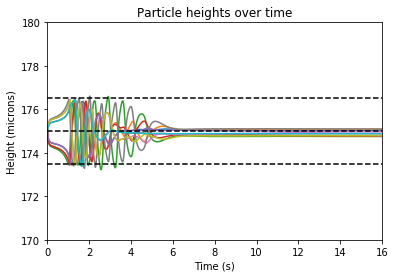

In [135]:
for n in range(num_particles):
    plt.plot(np.array(times), z_pos[:,n])
plt.plot(z_pos[:,n]*0 + z_range[1],'k')
plt.plot(z_pos[:,n]*0 + z_range[0],'k')
plt.plot(z_pos[:,n]*0 + z_center, 'k--')
plt.plot(z_pos[:,n]*0 + z_center+radius, 'k--')
plt.plot(z_pos[:,n]*0 + z_center-radius, 'k--')
plt.ylim([170,180])
plt.xlim([0,time_step*total_steps])
plt.title('Particle heights over time')
plt.xlabel('Time (s)')
plt.ylabel('Height (microns)')

In [4]:
# Notes: an imposed vortex + standing wave seem to be enough to get particles to line up even without
# acoustic interactions. Check this more and compare for different cases.
# See if same happens if each particle has a torque that is generating the rotational flow
# See if current flow magnitude is reasonable for a vortex in acoustic streaming
# Rewrite integration steps to conserve energy (currently, a vortex with no other forces has particles slowly spiral outwards)

In [ ]:
anim.save('E0_100_Spheres_50Hz_VerticallyAligned.mp4')

In [132]:
test = np.zeros(12)
for i in range(6):
    test[i] = 1+i
    test[-i-1] = 1+i
test

array([1., 2., 3., 4., 5., 6., 6., 5., 4., 3., 2., 1.])